In [ ]:
# read libraries
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

import pymc3 as pm
import arviz as az
import theano

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.simplefilter('ignore')

# 1.線形回帰モデル

##  サンプルデータを生成

In [ ]:
size = 100
X = st.norm.rvs(size=[size, 5])
w = st.norm.rvs(size=5)
intercept = st.norm.rvs()
noize = st.norm.rvs(size=size)
y = X @ w + intercept + noize

df = pd.DataFrame(X, columns=['X0', 'X1', 'X2', 'X3', 'X4'])
df['y'] = y
df.head()

,X0,X1,X2,X3,X4,y
0,0.158228,0.074367,-1.965017,1.689488,2.905612,-9.108042
1,-0.633142,0.224677,0.088762,-0.206894,0.054709,-1.981499
2,-0.198236,-0.298961,0.074851,-0.235276,0.573335,-3.807672
3,-0.212915,-0.209864,-0.346285,1.081313,0.263430,-1.680309
4,-0.790810,-0.935944,-0.852356,0.513401,0.117660,-6.636258


## train test に分割

In [ ]:
train, test = train_test_split(df, test_size=0.3)
print(train.shape)
print(test.shape)

(70, 6)
(30, 6)


##  目的変数と説明変数を定義

In [ ]:
observed_col = 'y'
feature_cols = ['X0', 'X1', 'X2', 'X3', 'X4']

## モデルを作成

In [ ]:
def model_linear(df, feature_cols, observed_col):
  with pm.Model() as model:
    pm_w = pm.Normal('pm_w', mu=0, sd=10, shape=len(feature_cols))
    pm_intercept = pm.Normal('pm_intercept', mu=0, sd=10)
    pm_mu = pm.math.dot(df[feature_cols], pm_w) + pm_intercept
    pm_sd = pm.Gamma('pm_sd', alpha=1.0, beta=1.0)
    pm_y = pm.Normal('pm_y', mu=pm_mu, sd=pm_sd, observed=df[observed_col])
  return model

## パラメーターの推論

In [ ]:
with model_linear(train, feature_cols, observed_col) as model:
  train_trace = pm.sample(1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [pm_sd, pm_intercept, pm_w]
100%|██████████| 1500/1500 [00:02<00:00, 650.11it/s]


## y pred を出力

In [ ]:
with model_linear(test, feature_cols, observed_col) as test_model:
    # 予測分布は sample_posterior_predictive 関数を使う.
    # 引数には↑のセルで出力した trace オブジェクトを与える
    # サンプル数は任意,↑のセルのサンプル数と合わせなくてもOK.
    post_pred = pm.sample_posterior_predictive(train_trace, samples=1000)

100%|██████████| 1000/1000 [00:01<00:00, 750.15it/s]


In [ ]:
# 1000 * 30 になっている理由は サンプル数が1000でデータ数が30件であるため
# 予測1レコードごとに1000件のサンプルがあるので、分布を出力してもOK.
post_pred['pm_y'].shape

(1000, 30)

## スコアを計測（機械学習っぽいやり方）



In [ ]:
y_pred = post_pred['pm_y'].mean(axis=0)
rmse = np.sqrt(mean_squared_error(test[observed_col], y_pred))
print('RMSE:', rmse)
r2 = r2_score(test[observed_col], y_pred)
print('決定係数:', r2)

RMSE: 1.1077191857865938
決定係数: 0.8247985217773162


##  完全未知データで推論を行う

In [ ]:
newX = st.norm.rvs(size=[100, 5])
newdf = pd.DataFrame(newX, columns=['X0', 'X1', 'X2', 'X3', 'X4'])
newdf['y'] = 0 # y は情報なしにするため 0 を代入
newdf.head()

,X0,X1,X2,X3,X4,y
0,0.348174,0.721636,-0.747753,0.293692,0.046603,0
1,0.365831,0.455147,-2.221042,-0.262176,-0.144353,0
2,-1.146811,0.195364,0.359741,-0.977433,0.397494,0
3,0.940965,1.213365,0.283179,0.149425,0.622666,0
4,0.997971,0.872086,-0.066584,0.775869,-0.347193,0


In [ ]:
with model_linear(newdf, feature_cols, observed_col) as test_model:
    pred = pm.sample_posterior_predictive(train_trace, samples=1000)

100%|██████████| 1000/1000 [00:01<00:00, 751.13it/s]


In [ ]:
# サンプル平均を予測値とする
y_pred = pred['pm_y'].mean(axis=0)

## 真の値との比較

In [ ]:
y_true = newX @ w + intercept # 真の値を算出

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE:', rmse)
r2 = r2_score(y_true, y_pred)
print('決定係数:', r2)

RMSE: 0.32466638586177726
決定係数: 0.9760824976243715


真の y と予測のyをplot

真の y を昇順に並び替えて、散布図を描く

同様に予測値も昇順に並び替えて散布図を描く

灰色の区間は95%区間（正規分布を仮定）

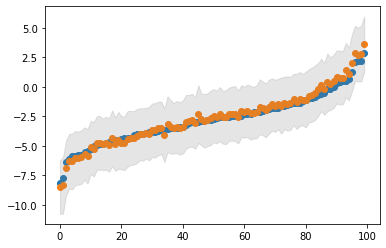

In [ ]:
x = range(len(y_true))
idx = np.argsort(y_true)
plt.scatter(x, y_true[idx])
plt.scatter(x, y_pred[idx])

norm_dist = st.norm(loc=y_pred[idx], scale=pred['pm_y'].std(axis=0)[idx])
low_interval = norm_dist.ppf(0.025)
high_interval = norm_dist.ppf(0.975)

plt.fill_between(x, low_interval, high_interval, color='gray', alpha=0.2)

# サンプルデータの件数を減らすと、以下の図の傾向が大きく変わり分散が大き箇所と小さい箇所が大きく異なるようになる.
# つまり、学習時に出現したデータの組み合わせでは自信を持って推論するが、情報が不足している予測値については自信がないので区間が広くなる

# 2.階層モデル（observed が複数ある場合）

## サンプルデータを生成

In [ ]:
sizeA = 1000
sizeB = 1500

X_A = st.norm.rvs(size=[sizeA, 4]) 
X_A[:, 0] = 1

X_B = st.norm.rvs(size=[sizeB, 4])
X_B[:, 0] = 1

w_A = st.norm.rvs(size=3)
w_B = st.norm.rvs(size=3)

common_w = st.norm.rvs() # 共通因子

y_A = X_A[:, :3] @ w_A + X_A[:,  3] * common_w + st.norm.rvs(scale=1, size=sizeA)
y_B = X_B[:, :3] @ w_B + X_B[:,  3] * common_w + st.norm.rvs(scale=3, size=sizeB) # わざとノイズの大きさを変えてみる

dfA = pd.DataFrame(X_A, columns=['bias', 'X0', 'X1', '共通因子にかかる変数'])
dfA['y'] = y_A
dfA.head()

,bias,X0,X1,共通因子にかかる変数,y
0,1.0,0.410871,-0.210094,0.218984,0.032981
1,1.0,0.086297,1.579704,0.221480,-0.478874
2,1.0,1.863602,-0.275055,0.904003,0.066678
3,1.0,1.464943,-1.374338,0.163686,-2.330548
4,1.0,0.423440,-1.569453,2.004510,-3.257610


In [ ]:
dfB = pd.DataFrame(X_B, columns=['bias', 'X0', 'X1', '共通因子にかかる変数'])
dfB['y'] = y_B
dfB.head()

,bias,X0,X1,共通因子にかかる変数,y
0,1.0,1.696932,2.711823,-1.537411,-6.304780
1,1.0,0.043390,0.071404,-0.786900,-1.940645
2,1.0,3.270790,0.368157,-0.929773,-4.237708
3,1.0,1.385763,0.596853,-0.934194,0.938585
4,1.0,-0.736587,-1.717290,1.439770,3.493331


## train test に分割

In [ ]:
trainA, testA = train_test_split(dfA, test_size=0.3)
trainB, testB = train_test_split(dfB, test_size=0.3)

## 各変数名称を定義

In [ ]:
observed_col = 'y'
feature_cols = ['bias', 'X0', 'X1']
common_cols = '共通因子にかかる変数'

## モデルを作成

In [ ]:
def hierarchical_model(dfA, dfB, feature_cols, observed_col, common_cols):
  with pm.Model() as model:
    pm_w_A = pm.Normal('pm_w_A', mu=0, sd=10, shape=3)
    pm_w_B = pm.Normal('pm_w_B', mu=0, sd=10, shape=3)

    pm_common = pm.Normal('pm_common', mu=0, sd=10)

    pm_mu_A = pm.math.dot(dfA[feature_cols], pm_w_A) + pm_common * dfA[common_cols]
    pm_mu_B = pm.math.dot(dfB[feature_cols], pm_w_B) + pm_common * dfB[common_cols]

    pm_sd_A = pm.Gamma('pm_sd_A', alpha=1.0, beta=1.0)
    pm_sd_B = pm.Gamma('pm_sd_B', alpha=1.0, beta=1.0)

    pm_y_A = pm.Normal('pm_y_A', mu=pm_mu_A, sd=pm_sd_A, observed=dfA[observed_col])
    pm_y_B = pm.Normal('pm_y_B', mu=pm_mu_B, sd=pm_sd_B, observed=dfB[observed_col])
  return model

## パラメーターの推論

In [ ]:
with hierarchical_model(trainA, trainB, feature_cols, observed_col, common_cols) as model:
  train_trace = pm.sample(1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [pm_sd_B, pm_sd_A, pm_common, pm_w_B, pm_w_A]
100%|██████████| 1500/1500 [00:02<00:00, 523.65it/s]


## pred を出力

In [ ]:
with hierarchical_model(testA, testB, feature_cols, observed_col, common_cols) as test_model:
    post_pred = pm.sample_posterior_predictive(train_trace, samples=1000)

100%|██████████| 1000/1000 [00:02<00:00, 412.19it/s]


In [ ]:
# 2つの変数が格納されている
post_pred.keys()

dict_keys(['pm_y_A', 'pm_y_B'])

In [ ]:
print(post_pred['pm_y_A'].shape)
print(post_pred['pm_y_B'].shape)

(1000, 300)
(1000, 450)


## スコアを計測（機械学習っぽいやり方）

In [ ]:
y_predA = post_pred['pm_y_A'].mean(axis=0)
rmse = np.sqrt(mean_squared_error(testA[observed_col], y_predA))
print('A RMSE:', rmse)
r2 = r2_score(testA[observed_col], y_predA)
print('A 決定係数:', r2)

A RMSE: 1.0105973408686435
A 決定係数: 0.6529240780710488


In [ ]:
y_predB = post_pred['pm_y_B'].mean(axis=0)
rmse = np.sqrt(mean_squared_error(testB[observed_col], y_predB))
print('B RMSE:', rmse)
r2 = r2_score(testB[observed_col], y_predB)
print('B 決定係数:', r2)

B RMSE: 3.0844209475012265
B 決定係数: 0.15246783421851806
